# First experiments with all LFI data

In [1]:
# Importing all packages
# normalizing flows packages
import torch
from torch.utils.data import TensorDataset, DataLoader
import normflows as nf

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import Scores, LambdaScore, WaldoScore, BFFScore, E_valueScore
from CP2LFI.simulations import predict_naive_quantile
from CP2LFI.posterior_models import normflow_posterior
from clover import LocartSplit

# quantile regression
from sklearn.ensemble import HistGradientBoostingRegressor

# plotting and numpy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import itertools
import pandas as pd

# package to simulate from weinberg LFI data
# weinberg data (physics)
from hypothesis.benchmark import weinberg
# mg1 data (queue theory)
from hypothesis.benchmark import mg1
# multivariate normal (toy example)
from hypothesis.benchmark import tractable

## Defining general functions to make the comparisons:

First, implementing naive quantiles and prediction:

In [2]:
# defining naive function
def naive(kind, simulator, score, alpha, B=1000, N=100, naive_n=500, disable_tqdm = True):
    n_grid = int(B / naive_n)
    quantiles = {}

    if kind == "weinberg":
        thetas = np.linspace(0.5001, 1.4999, n_grid)
        for theta in thetas:
            theta_fixed = torch.tensor([theta])
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(repeats = naive_n*N, dim = 0)
            X_samples = simulator(repeated_thetas)
            X_dim = X_samples.shape[1]
            X_samples = X_samples.reshape(naive_n, N * X_dim)

            lambdas = score.compute(thetas = repeated_thetas.numpy()[0:naive_n, :], X = X_samples.numpy(), disable_tqdm = disable_tqdm)

            quantiles[theta] = np.quantile(lambdas, q = 1 - alpha)

    elif kind == "tractable":
        # given the complexity, reducing to only 10 grid if B > 5000
        if B > 5000:
            n_grid = 10
        par_grid = np.linspace(-2.9999, 2.9999, n_grid)
        for theta_1, theta_2, theta_3, theta_4, theta_5 in itertools.product(par_grid, par_grid, par_grid, par_grid, par_grid):
            theta_fixed = torch.tensor([theta_1, theta_2, theta_3, theta_4, theta_5])
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(repeats = naive_n*N, dim = 0)
            X_samples = simulator(repeated_thetas)
            X_dim = X_samples.shape[1]
            X_samples = X_samples.reshape(naive_n, N * X_dim)

            lambdas = score.compute(thetas = repeated_thetas.numpy()[0:naive_n, :], X = X_samples.numpy())

            quantiles[(theta_1, theta_2, theta_3, theta_4, theta_5)] = np.quantile(lambdas, q = 1 - alpha)

    elif kind == "mg1":
        pars_1 = np.linspace(0.0001, 9.9999, n_grid)
        pars_2 = np.linspace(0.0001, 1/3 - 0.0001, n_grid)
        for par1, par2, par3 in itertools.product(pars_1, pars_1, pars_2):
            theta_fixed = torch.tensor([par1, par2, par3])
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(repeats = naive_n*N, dim = 0)
            X_samples = simulator(repeated_thetas)
            X_dim = X_samples.shape[1]
            X_samples = X_samples.reshape(naive_n, N * X_dim)

            lambdas = score.compute(thetas = repeated_thetas.numpy()[0:naive_n, :], X = X_samples.numpy())

            quantiles[(theta_1, theta_2, theta_3)] = np.quantile(lambdas, q = 1 - alpha)
    return quantiles

# prediction function for naive
def predict_naive_quantile(kind, theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        if kind == "weinberg":
            idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
            quantiles_list.append(quantiles_dict[idx])
        else:
            distances = np.linalg.norm(thetas_values - theta, axis=1)
            idx = thetas_values[np.argmin(distances)]
            quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

Now, implementing function for obtaining quantile in LFI version:

In [3]:
def obtain_quantiles(
    kind,
    score,
    theta_grid_eval,
    simulator,
    prior,
    N,
    B=1000,
    alpha=0.05,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 50,
    B_valid=1000,
    N_lambda = 150,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 95, 5))),
    naive_n=500,
    disable_tqdm = True,
):
    # fitting and predicting naive (monte-carlo
    print("Running naive method")
    naive_quantiles = naive(kind = kind, simulator = simulator, score = score, alpha = alpha, B=B, N=N, naive_n= naive_n)
    naive_list = predict_naive_quantile(kind, theta_grid_eval, naive_quantiles)

    # simulating to fit models
    thetas_sim = prior.sample((B,))
    if thetas_sim.ndim == 1:
        model_thetas = thetas_sim.reshape(-1, 1)
    else:
        model_thetas = thetas_sim

    repeated_thetas = thetas_sim.repeat_interleave(repeats = N, dim = 0)
    X_net = simulator(repeated_thetas)
    X_dim = X_net.shape[1]
    X_net = X_net.reshape(B, N * X_dim)

    model_lambdas = score.compute(model_thetas.numpy(), X_net.numpy(), disable_tqdm = disable_tqdm)

    print("Running all the other methods")
    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas.numpy(), model_lambdas, min_samples_leaf=min_samples_leaf
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas.numpy(), 
        model_lambdas, 
        min_samples_leaf=min_samples_leaf, 
        n_estimators= n_estimators,
        K = K,
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas.numpy(), model_lambdas)

    print("Obtaining tuning sample")
    # tuned loforest samples
    theta_tune = prior.sample((B_valid, ))

    # finding tuned K
    lambda_tune = np.zeros((theta_tune.shape[0], N_lambda))
    if theta_tune.ndim == 1:
        K_valid_thetas = theta_tune.reshape(-1, 1)
    else:
        K_valid_thetas = theta_tune

    i = 0
    for theta in tqdm(theta_tune, desc = "Simulating all tuning sample"):
        if theta_tune.ndim == 1:
            theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = N_lambda*N, dim = 0)
        else:
            theta.reshape(1, -1).repeat_interleave(repeats = N_lambda*N, dim = 0)
        X_net = simulator(theta_repeated)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(N_lambda, N * X_dim)
        lambda_tune[i, :] = score.compute(thetas = theta_repeated.numpy()[0:N_lambda, :], X = X_net.numpy(), disable_tqdm = disable_tqdm)
        i += 1

    print("Fitting tuned loforest")
    K_loforest = tune_loforest_LFI(
        loforest_object, theta_data = K_valid_thetas.numpy(), lambda_data = lambda_tune, K_grid=K_grid
    )

    # locart quantiles
    model_eval = theta_grid_eval.reshape(-1, 1)

    idxs = locart_object.cart.apply(model_eval)
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(model_eval)

    # tuned loforest
    loforest_tuned_cutoffs = loforest_object.compute_cutoffs(
        model_eval, K=K_loforest
    )

    # boosting
    boosting_quantiles = model.predict(model_eval)


    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest_fixed": loforest_cutoffs,
        "loforest_tuned": loforest_tuned_cutoffs,
        "boosting": boosting_quantiles,
    }

    return quantile_dict

Function to compute MAE for a fixed N and B:

In [4]:
def compute_MAE_N_B(
    kind,
    score,
    theta_grid_eval,
    simulator,
    prior,
    N = 1,
    B = 10000,
    alpha=0.05,
    min_samples_leaf = 300,
    n_estimators = 200,
    K = 50,
    B_valid= 500,
    N_lambda = 250,
    K_grid= np.concatenate((np.array([0]), np.arange(15, 95, 5))),
    naive_n=500,
    disable_tqdm = True,
    seed = 45,
    n_lambda = 300,
):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    quantiles_dict = obtain_quantiles(
    kind = kind, 
    score = score, 
    theta_grid_eval = theta_grid_eval, 
    simulator = simulator,
    prior = prior, 
    N = N, 
    B = B, 
    alpha = alpha, 
    min_samples_leaf = min_samples_leaf, 
    n_estimators = n_estimators, 
    K = K,
    disable_tqdm = disable_tqdm,
    B_valid = B_valid,
    N_lambda= N_lambda,
    K_grid = K_grid,
    naive_n = naive_n
)
    mae_list, se_list, methods_list, N_list, B_list = [], [], [], [], []
    err_data = np.zeros((theta_grid_eval.shape[0], 5))
    l = 0
    for theta in tqdm(theta_grid_eval, desc = "Evaluating coverage in this setting"):
        if theta_grid_eval.ndim == 1:
            theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*N, dim = 0)
        else:
            theta_repeated = theta.reshape(1, -1).repeat_interleave(repeats = n_lambda*N, dim = 0)
        # simulating lambdas for testing
        X_net = simulator(theta_repeated)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(n_lambda, N * X_dim)

        stat = score.compute(theta_repeated.numpy()[0:n_lambda, :], X_net.numpy(), disable_tqdm = True)
                
        # comparing coverage of methods
        locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
        loforest_cover = np.mean(stat <= quantiles_dict["loforest_fixed"][l])
        loforest_tuned_cover = np.mean(stat <= quantiles_dict["loforest_tuned"][l])
        boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
        naive_cover = np.mean(stat <= quantiles_dict["naive"][l])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_loforest_tuned = np.abs(loforest_tuned_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))
        
            # saving in numpy array
        err_data[l, :] = np.array([err_locart, err_loforest, err_loforest_tuned, err_boosting, err_naive])
        l += 1

    mae_list.extend(np.mean(err_data, axis=0).tolist())
    se_list.extend((np.std(err_data, axis=0) / np.sqrt(theta_grid_eval.shape[0])).tolist())
    methods_list.extend(["LOCART", "LOFOREST", "tuned LOFOREST", "boosting", "monte-carlo"])
    N_list.extend([N] * 5)
    B_list.extend([B] * 5)

    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [5]:
def fit_post_model(
        simulator, 
        prior, 
        B_model = 20000, 
        n = 1, 
        seed = 45, 
        split_seed = 0,
        n_flows = 8, 
        hidden_units = 128,
        hidden_layers = 2,
        enable_cuda = True,
        patience = 50,
        n_epochs = 2000,
        batch_size = 250,
        plot_history = True):

        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        # simulating thetas
        thetas = prior.sample((B_model, ))
        repeated_thetas = thetas.repeat_interleave(repeats = n, dim = 0)

        # simulating X's
        X_sample = simulator(repeated_thetas)
        X_dim = X_sample.shape[1]
        X_net = X_sample.reshape(B_model, n * X_dim)

        if thetas.ndim == 1:
                thetas = thetas.reshape(-1, 1)
        nflow_post = normflow_posterior(
        latent_size = thetas.shape[1],
        sample_size = X_net.shape[1], 
        n_flows = n_flows, 
        hidden_units = hidden_units, 
        hidden_layers = hidden_layers,
        enable_cuda = enable_cuda,
        )

        nflow_post.fit(
                X_net.numpy(), 
                thetas.numpy(), 
                patience = patience, 
                n_epochs = n_epochs, 
                batch_size = batch_size, 
                split_seed = split_seed
                )
        if plot_history:
                nflow_post.plot_history()
        
        return nflow_post

## Starting by the weinberg data:

Simulating and testing for tractable:

In [6]:
simulator = weinberg.Simulator(default_beam_energy=40.0)
prior = weinberg.Prior()

Starting by samples size $n = 5$ and $B^{'} = 20000$ for posterior modeling. Fitting normalizing flow model and analysing loss:

Fitting normalizing flows posterior estimator:  13%|█▎        | 264/2000 [01:25<09:19,  3.10it/s]

Early stopping at epoch 264
a


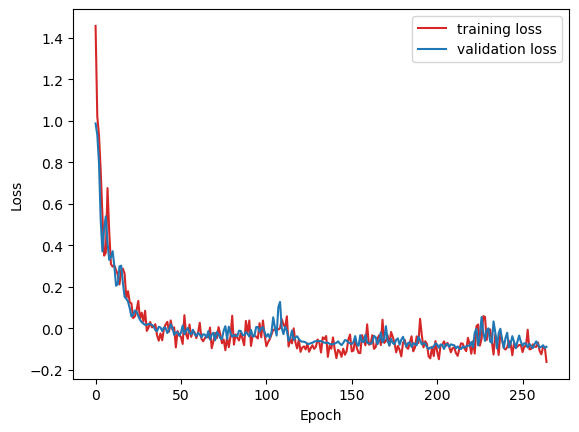

In [7]:
nflow_post = fit_post_model(simulator = simulator, prior = prior, B_model = 20000, n = 5, seed = 45, split_seed = 0)

Now, fixing a grid and declaring all statistics that will be used in the comparisons:

In [8]:
# weinberg grid
n_out = 300
thetas_valid = np.linspace(0.5001, 1.4999, n_out)

# defining scores
# waldo score
waldo_score = WaldoScore(nflow_post, is_fitted = True)
waldo_score.fit()

# BFF score
bff_score = BFFScore(nflow_post, is_fitted = True)
bff_score.fit()

# e-value score
e_value_score = E_valueScore(nflow_post, is_fitted = True)
e_value_score.fit()

# sample size
n = 1
B = 10000

### Computing coverage for fixed $n$ and $B$:

Computing for waldo:

In [35]:
waldo_stats_weinberg = compute_MAE_N_B(
    kind = "weinberg", 
    score = waldo_score, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 500, 
    N_lambda = 200,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 300,
    )

Running naive method
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 500/500 [27:01<00:00,  3.24s/it]


Fitting tuned loforest


Evaluating coverage in this setting: 100%|██████████| 300/300 [24:00<00:00,  4.80s/it]


In [36]:
waldo_stats_weinberg

,methods,N,B,MAE,se
0,LOCART,5,10000,0.014722,0.000588
1,LOFOREST,5,10000,0.013244,0.000547
2,tuned LOFOREST,5,10000,0.013544,0.000547
3,boosting,5,10000,0.015067,0.000796
4,monte-carlo,5,10000,0.013411,0.000582


Computing for BFF:

In [37]:
bff_stats_weinberg = compute_MAE_N_B(
    kind = "weinberg", 
    score = bff_score,
    seed = 125,
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 1000, 
    N_lambda = 500,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 300
    )

Running naive method
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample: 100%|██████████| 1000/1000 [03:23<00:00,  4.91it/s]


Fitting tuned loforest


Evaluating coverage in this setting: 100%|██████████| 300/300 [00:39<00:00,  7.59it/s]


In [38]:
bff_stats_weinberg

,methods,N,B,MAE,se
0,LOCART,5,10000,0.017944,0.000938
1,LOFOREST,5,10000,0.017767,0.001184
2,tuned LOFOREST,5,10000,0.017744,0.001188
3,boosting,5,10000,0.015100,0.000680
4,monte-carlo,5,10000,0.015733,0.000798


Computing for e-value:

In [9]:
e_value_stats_weinberg = compute_MAE_N_B(
    kind = "weinberg", 
    score = e_value_score,
    seed = 150, 
    theta_grid_eval = thetas_valid, 
    simulator = simulator, 
    prior = prior, 
    N = 5, 
    B = 10000, 
    B_valid = 500, 
    N_lambda = 200,
    K = 70,
    n_estimators = 200,
    min_samples_leaf = 300,
    )

Running naive method
Running all the other methods
Obtaining tuning sample


Simulating all tuning sample:  87%|████████▋ | 436/500 [1:11:46<10:32,  9.88s/it]


KeyboardInterrupt: 

In [ ]:
e_value_stats_weinberg